In [1]:
import logging
import math
import os
import shutil
import time

In [2]:
import keras
from keras import layers, Sequential, Input
from keras.src.callbacks import ModelCheckpoint, EarlyStopping
from keras.src.optimizers import Adam, AdamW, RMSprop, SGD
from keras.src.utils import image_dataset_from_directory
from matplotlib import pyplot as plt
from pandas import DataFrame

2024-09-26 14:00:43.130701: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-26 14:00:43.826175: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
IMAGES_PATH = "resources/Images"
CROPPED_IMAGES_PATH = "resources/Cropped_Images2"
MODELS_PATH = "models/custom_model"
MODEL_SAVE_PATH = f"{MODELS_PATH}/custom_model.keras"

To optimize GPU memory consumption

In [4]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [5]:
def remove_last_generated_models():
    shutil.rmtree(MODELS_PATH, ignore_errors=True)
    os.makedirs(MODELS_PATH)

In [6]:
def get_dataset(path, image_size, batch_size, validation_split=0.0, data_type=None):
    return image_dataset_from_directory(
        path,
        labels='inferred',
        label_mode='categorical',
        class_names=None,
        batch_size=batch_size,
        image_size=image_size,
        seed=42,
        validation_split=validation_split,
        subset=data_type
    )

In [7]:
def get_optimizer(optimizer, learning_rate):
    match optimizer:
        case "adam":
            return Adam(learning_rate=learning_rate)
        case "adamw":
            return AdamW(learning_rate=learning_rate)
        case "rmsprop":
            return RMSprop(learning_rate=learning_rate)
        case "sgd":
            return SGD(learning_rate=learning_rate)
        case "sgdn":
            return SGD(learning_rate=learning_rate, nesterov=True)
        case _:
            raise ValueError(f"Unknown optimizer:{optimizer}.")

In [8]:
def create_model(input_shape, labels_number, kernel_size=(3, 3), number_of_intermediate_layers=3, dropout_rate=0.2,
                 optimizer="adam", learning_rate=0.001):
    intermediate_layers = Sequential()
    
    for i in range(1, number_of_intermediate_layers + 1):
        intermediate_layers.add(layers.Conv2D(int(32 * math.pow(2, i)), kernel_size, padding='same'))
        intermediate_layers.add(layers.BatchNormalization())
        intermediate_layers.add(layers.Activation('relu'))
        intermediate_layers.add(layers.MaxPooling2D((2, 2)))
        
    model = Sequential([
        Input(shape=input_shape),

        # Data augmentation layers
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),

        # Core layers
        intermediate_layers,
        
        layers.GlobalAveragePooling2D(),
        layers.Dropout(dropout_rate),
        layers.Dense(labels_number, activation='softmax')
    ])
    
    optimizer = get_optimizer(optimizer, learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [9]:
def display_results(results, hyperparameter_name):
    results_df = DataFrame(results)
    
    display_results_plot(results_df, hyperparameter_name, ["fitting_time"], "fitting_time")
    display_results_plot(results_df, hyperparameter_name, ["test_accuracy", "val_accuracy"], "accuracies",
                         ascending=False)
    display_results_plot(results_df, hyperparameter_name, ["test_loss", "val_loss"], "losses")

In [10]:
def display_results_plot(results, hyperparameter_name, metrics, metrics_name, ascending=True):
    results.sort_values(metrics[0], ascending=ascending, inplace=True)
    performance_plot = (results[metrics + ["hyperparameters_name"]]
                        .plot(kind="line", x="hyperparameters_name", figsize=(15, 8), rot=0,
                              title=f"Results sorted by {metrics_name}"))
    
    performance_plot.title.set_size(20)
    performance_plot.set_xticks(range(0, len(results)))
    plt.xticks(rotation=90)
    performance_plot.set(xlabel=None)

    plt.show()
    plt.close()

In [11]:
def get_callbacks(with_early_stopping):
    checkpoint = ModelCheckpoint(MODEL_SAVE_PATH, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
    
    return [checkpoint, es] if with_early_stopping else [checkpoint]

In [12]:
def get_results_of_model(model, dataset_train, dataset_val, dataset_test, parameters, epoch=100, batch_size=16, with_early_stopping=True):
    fitting_start_time = time.time()
    model.fit(dataset_train,
                        validation_data=dataset_val,
                        batch_size=batch_size,
                        # epochs=2,
                        epochs=epoch,
                        callbacks=get_callbacks(with_early_stopping),
                        verbose=1)
    fitting_time = time.time() - fitting_start_time
    
    model.load_weights(MODEL_SAVE_PATH)
    
    val_loss, val_accuracy = model.evaluate(dataset_val, verbose=False)
    print(f"\nValidation Accuracy:{val_accuracy}.")
    
    test_loss, test_accuracy = model.evaluate(dataset_test, verbose=False)
    print(f"\nTest Accuracy:{test_accuracy}.\n")
    
    return {
        "hyperparameters_name": hyperparameters["name"],
        "fitting_time": fitting_time,
        "test_accuracy": test_accuracy,
        "test_loss": test_loss,
        "val_accuracy": val_accuracy,
        "val_loss": val_loss,
        **parameters
    }

In [13]:
def get_best_parameter(sorted_results, parameter_name):
    best_parameter = sorted_results[0][parameter_name]
    print(f"Best parameter:{parameter_name.replace("_", " ")} found:{best_parameter}.\n")
    return best_parameter

Starting custom models learning script.

Found 558 files belonging to 3 classes.
Using 419 files for training.


2024-09-26 14:00:44.977724: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-26 14:00:45.020969: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-26 14:00:45.023943: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Found 558 files belonging to 3 classes.
Using 139 files for validation.
Found 558 files belonging to 3 classes.

Testing now the parameters:{'number_of_intermediate_layers': 1}.

Epoch 1/100


2024-09-26 14:00:47.885623: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3900 - loss: 1.0868
Epoch 1: val_loss improved from inf to 3.09275, saving model to models/custom_model/custom_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.3921 - loss: 1.0848 - val_accuracy: 0.4460 - val_loss: 3.0928
Epoch 2/100
25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5317 - loss: 0.9709
Epoch 2: val_loss improved from 3.09275 to 1.55166, saving model to models/custom_model/custom_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.5289 - loss: 0.9714 - val_accuracy: 0.4460 - val_loss: 1.5517
Epoch 3/100
25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4816 - loss: 0.9901
Epoch 3: val_loss improved from 1.55166 to 1.37076, saving model to models/custom_model/custom_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.4866 - loss: 0.9867 - val_accuracy: 0.4388 - val_loss: 1.3708
Epoch 4/100
25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5369 - loss: 0.9356
Epo

2024-09-26 14:04:49.258987: W external/local_tsl/tsl/framework/bfc_allocator.cc:368] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.5108 - loss: 1.8226
Epoch 1: val_loss improved from inf to 50.92713, saving model to models/custom_model/custom_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - accuracy: 0.5128 - loss: 1.8027 - val_accuracy: 0.3022 - val_loss: 50.9271
Epoch 2/100
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.6337 - loss: 0.8483
Epoch 2: val_loss did not improve from 50.92713
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.6341 - loss: 0.8466 - val_accuracy: 0.3022 - val_loss: 76.3510
Epoch 3/100
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.6655 - loss: 0.8608
Epoch 3: val_loss improved from 50.92713 to 8.25575, saving model to models/custom_model/custom_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.6642 - loss: 0.8605 - val_accuracy: 0.4460 - val_loss: 8.2558
Epoch 4/100
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.6414 - loss: 0.8253
Epoch 4: val_loss improved from 8.25575 to 1.99562, savi

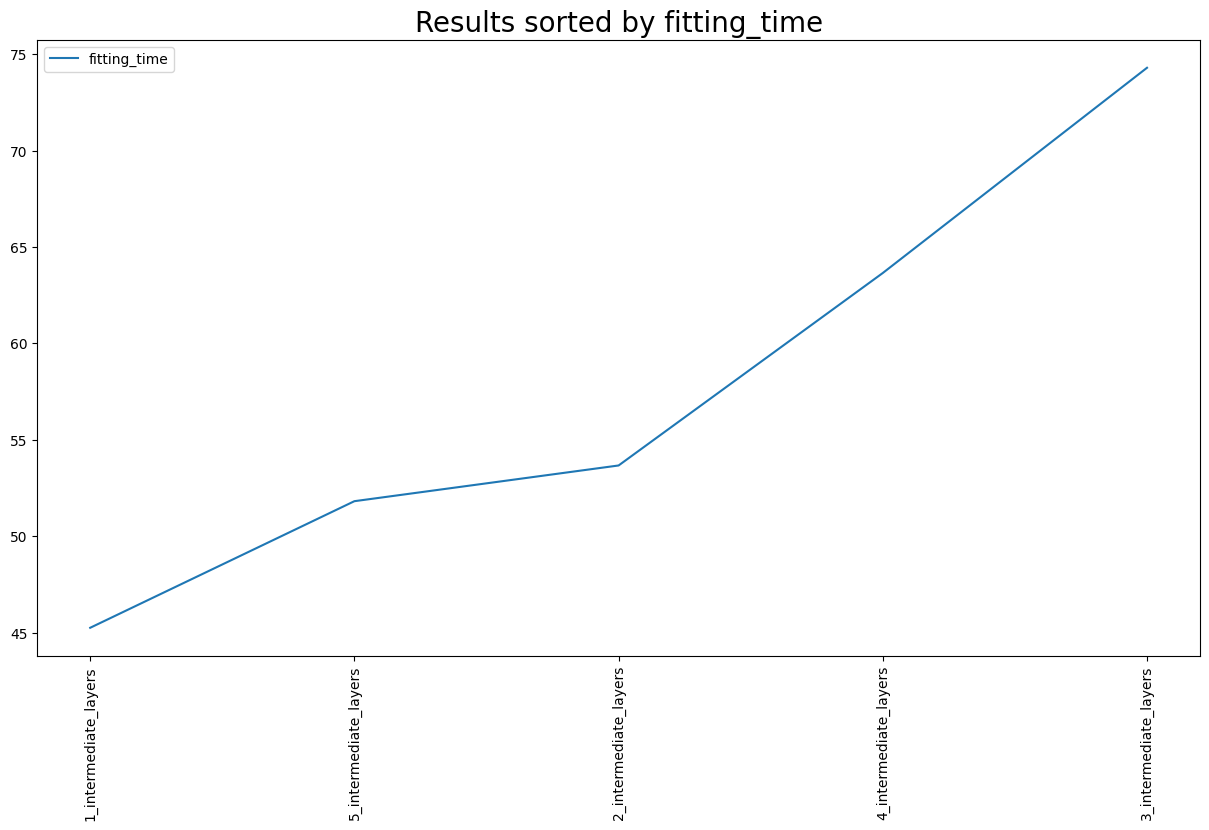

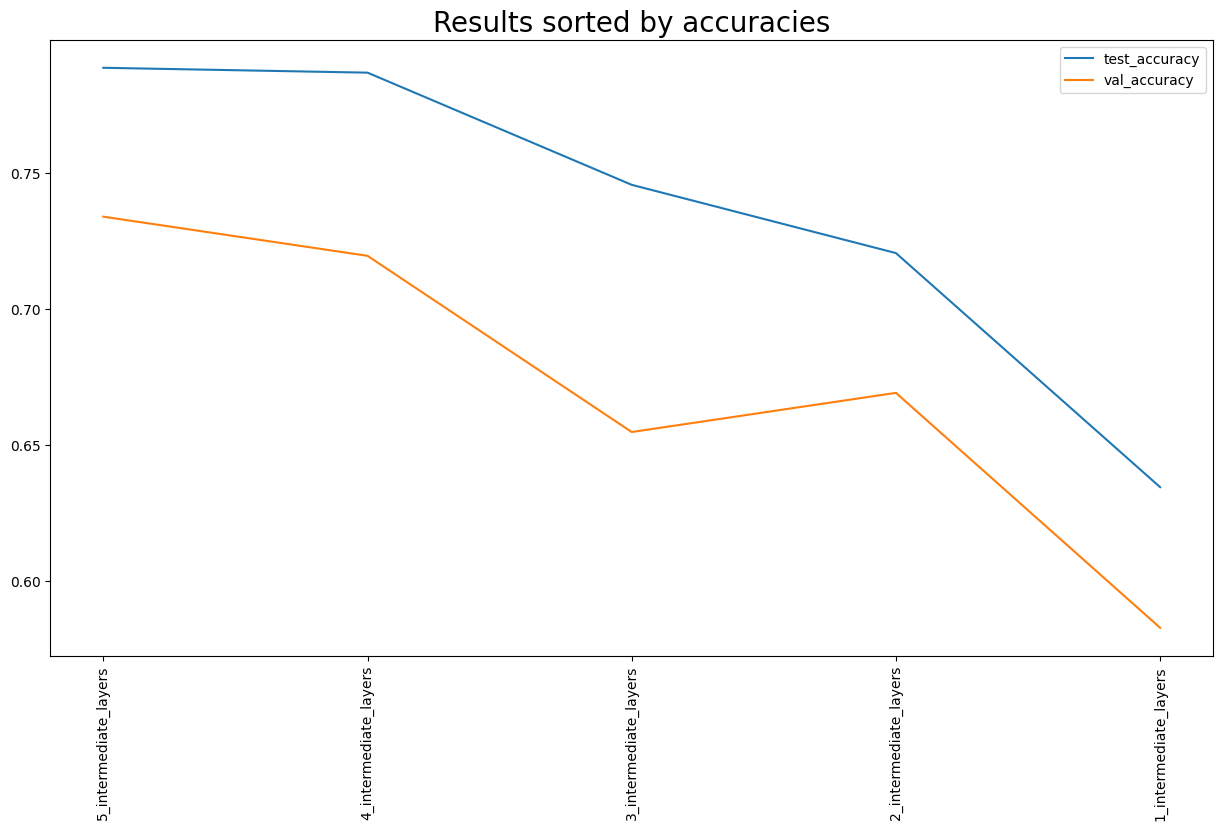

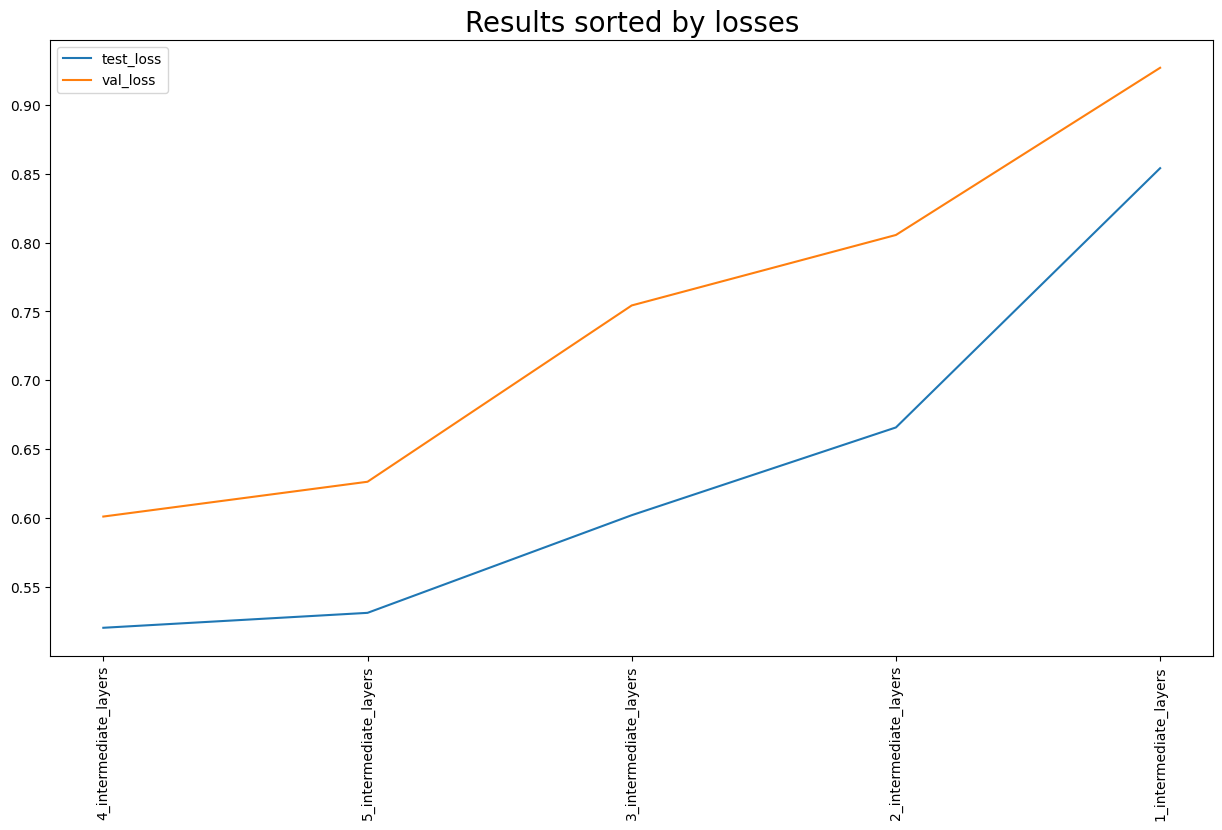

Testing now the parameters:{'kernel_size': (1, 1)}.

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.4254 - loss: 1.6689
Epoch 1: val_loss improved from inf to 1.89671, saving model to models/custom_model/custom_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - accuracy: 0.4290 - loss: 1.6574 - val_accuracy: 0.4173 - val_loss: 1.8967
Epoch 2/100
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.6823 - loss: 0.8241
Epoch 2: val_loss did not improve from 1.89671
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.6791 - loss: 0.8291 - val_accuracy: 0.3094 - val_loss: 3.4721
Epoch 3/100
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.6234 - loss: 0.9497
Epoch 3: val_loss did not improve from 1.89671
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.6231 - loss: 0.9467 - val_accuracy: 0.4029 - val_loss: 2.2216
Epoch 4/100
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.7210 - loss: 0.7309
Epoch 4: val_loss improved from 1.89671 to 1.42648, saving

2024-09-26 14:08:18.677417: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.28GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.4579 - loss: 2.9179

2024-09-26 14:08:23.307379: W external/local_tsl/tsl/framework/bfc_allocator.cc:368] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.4600 - loss: 2.8838
Epoch 1: val_loss improved from inf to 73.66470, saving model to models/custom_model/custom_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 255ms/step - accuracy: 0.4619 - loss: 2.8522 - val_accuracy: 0.3094 - val_loss: 73.6647
Epoch 2/100
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.5999 - loss: 0.8977
Epoch 2: val_loss improved from 73.66470 to 18.40979, saving model to models/custom_model/custom_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 0.6012 - loss: 0.8937 - val_accuracy: 0.3022 - val_loss: 18.4098
Epoch 3/100
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.7156 - loss: 0.7240
Epoch 3: val_loss improved from 18.40979 to 0.97905, saving model to models/custom_model/custom_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 0.7166 - loss: 0.7215 - val_accuracy: 0.6906 - val_loss: 0.9790
Epoch 4/100
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.7042 - lo

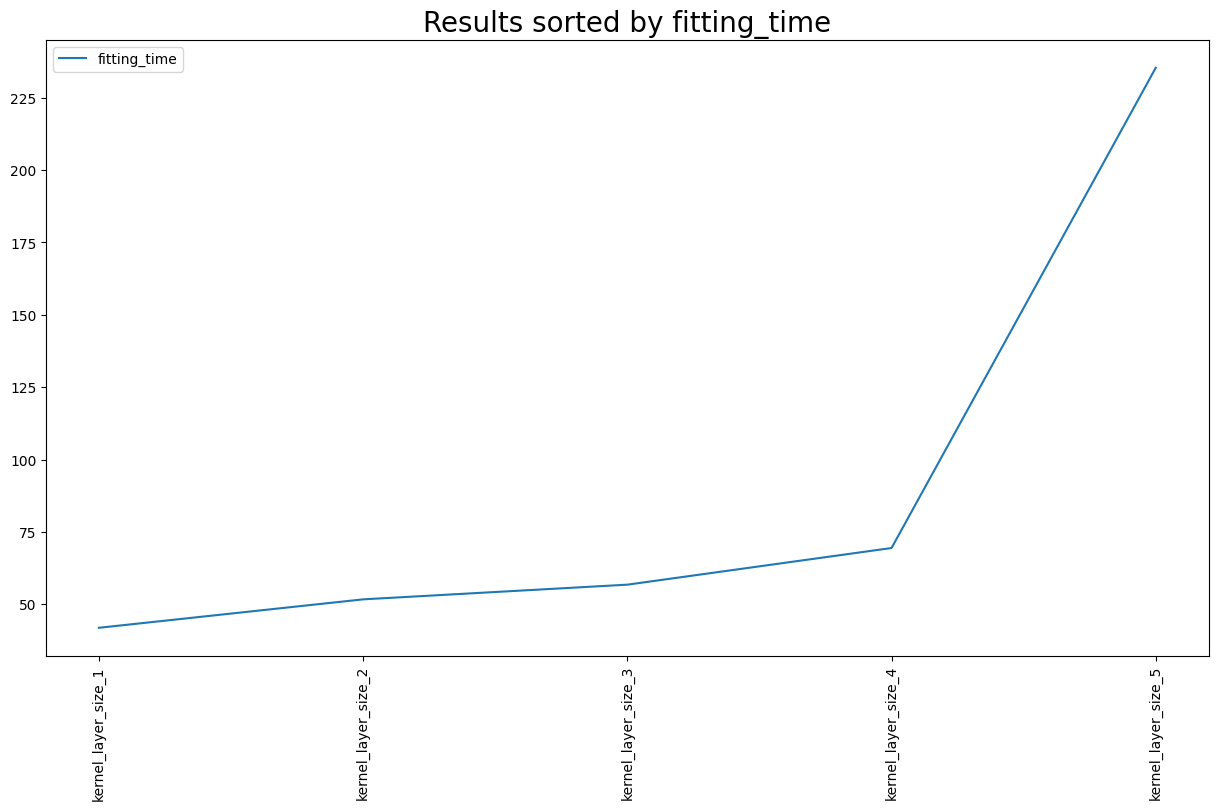

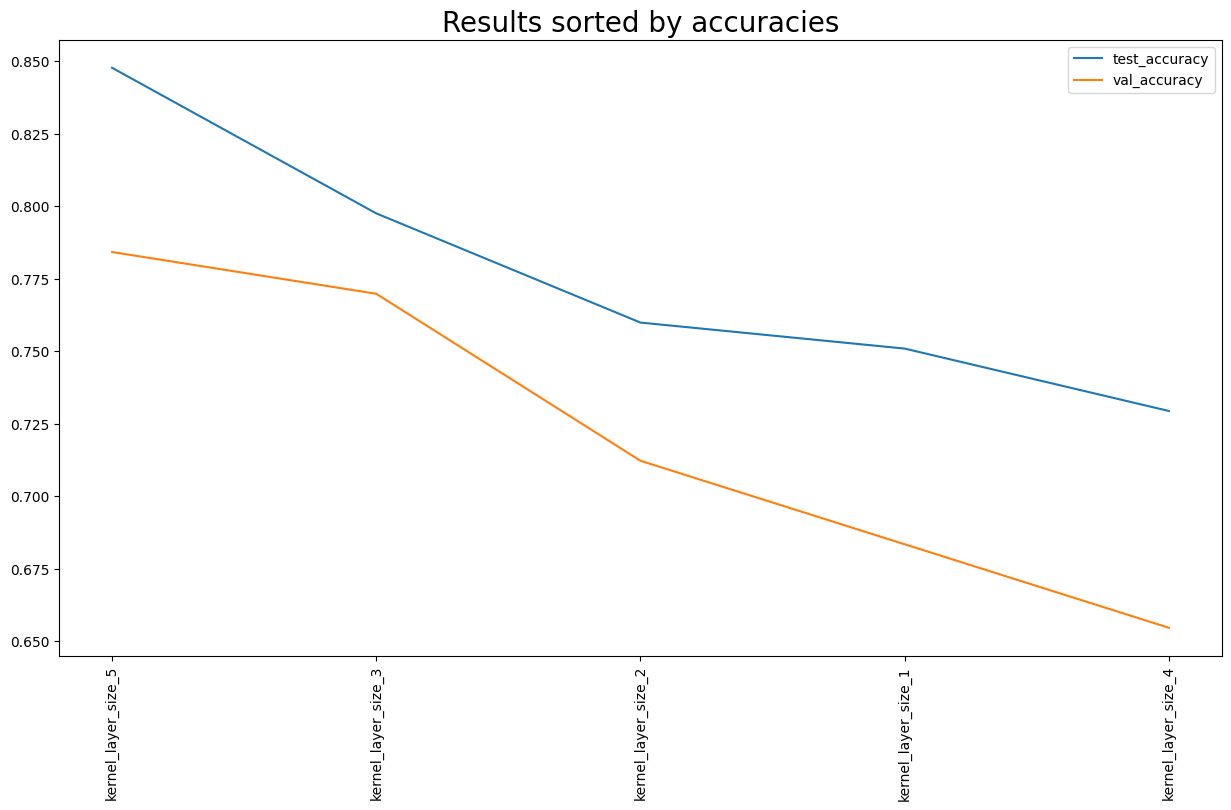

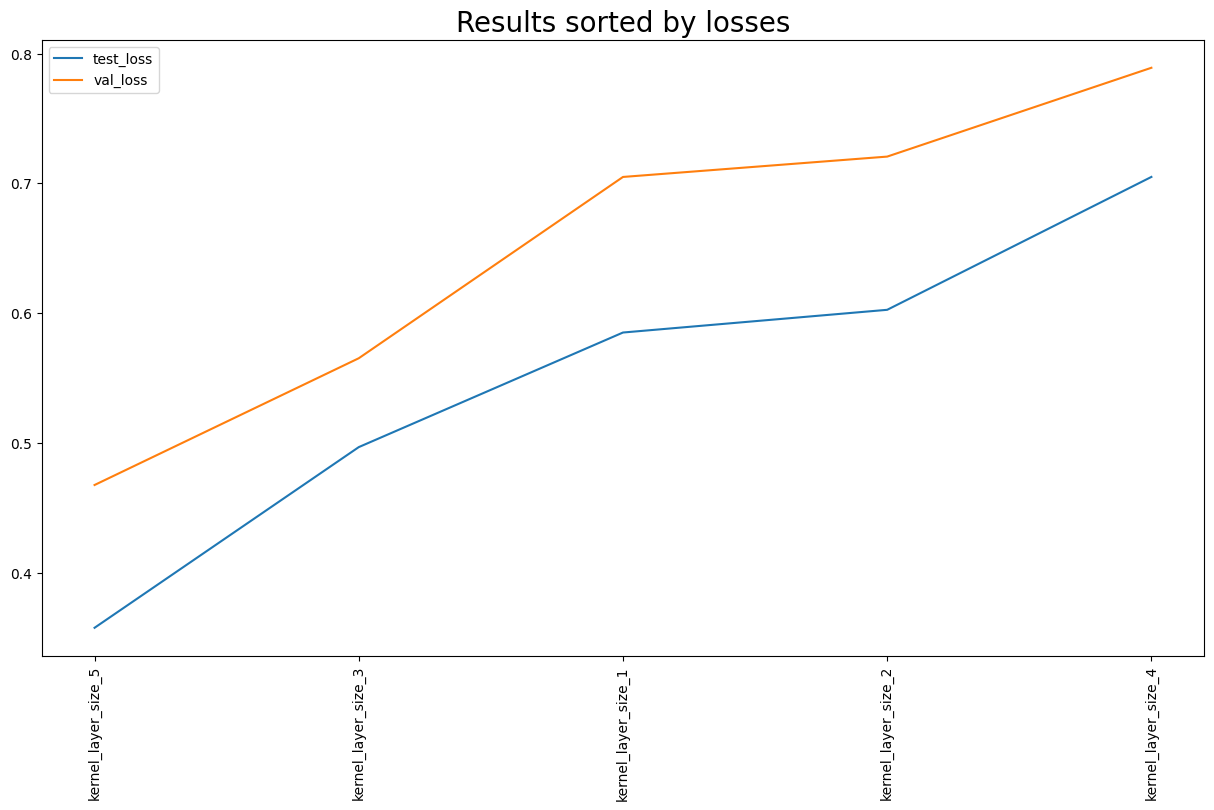

Testing now the parameters:{'dropout_rate': 0.1}.

Epoch 1/100
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.4881 - loss: 2.9964
Epoch 1: val_loss improved from inf to 67.82954, saving model to models/custom_model/custom_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 154ms/step - accuracy: 0.4950 - loss: 2.9151 - val_accuracy: 0.5468 - val_loss: 67.8295
Epoch 2/100
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.6594 - loss: 0.8071
Epoch 2: val_loss improved from 67.82954 to 45.82634, saving model to models/custom_model/custom_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 0.6621 - loss: 0.7984 - val_accuracy: 0.3022 - val_loss: 45.8263
Epoch 3/100
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.7020 - loss: 0.7841
Epoch 3: val_loss improved from 45.82634 to 3.98899, saving model to models/custom_model/custom_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 0.7002 - loss: 0.7840 - val_accuracy: 0.5899 - val_loss: 3.9890
Epoch 4/100
26

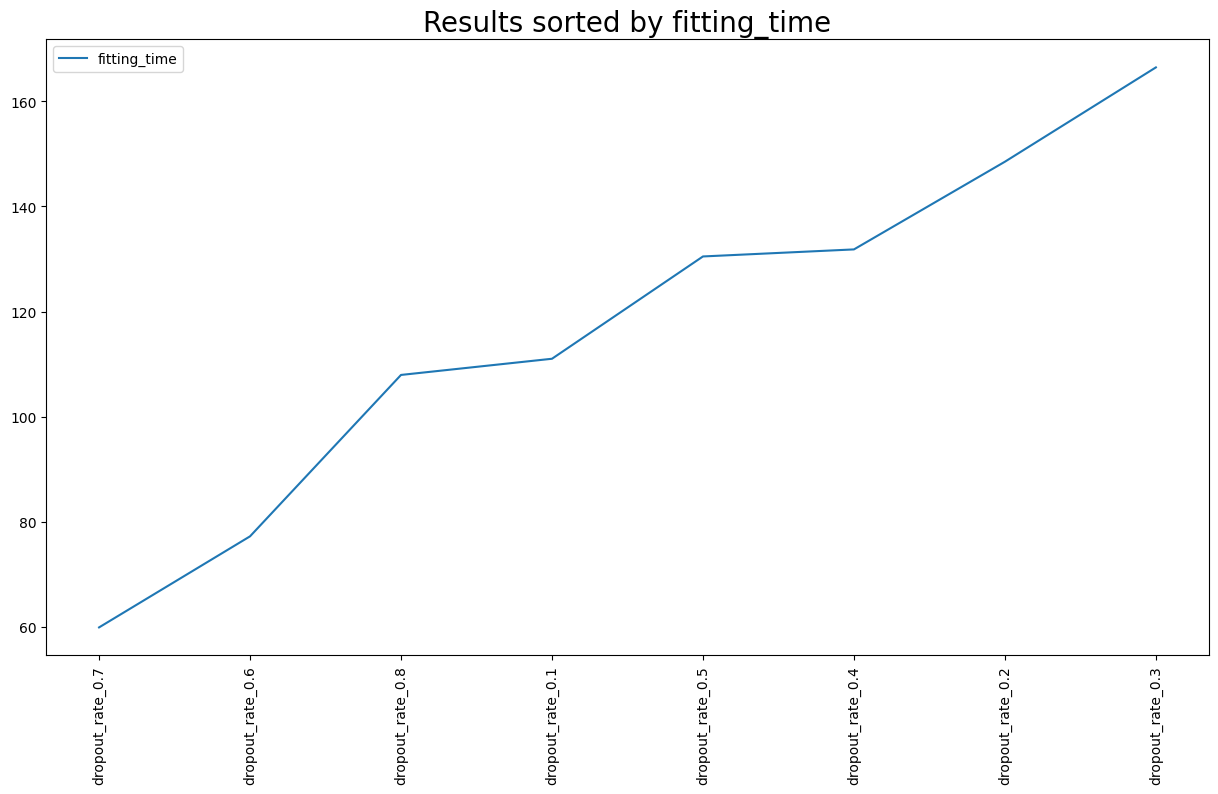

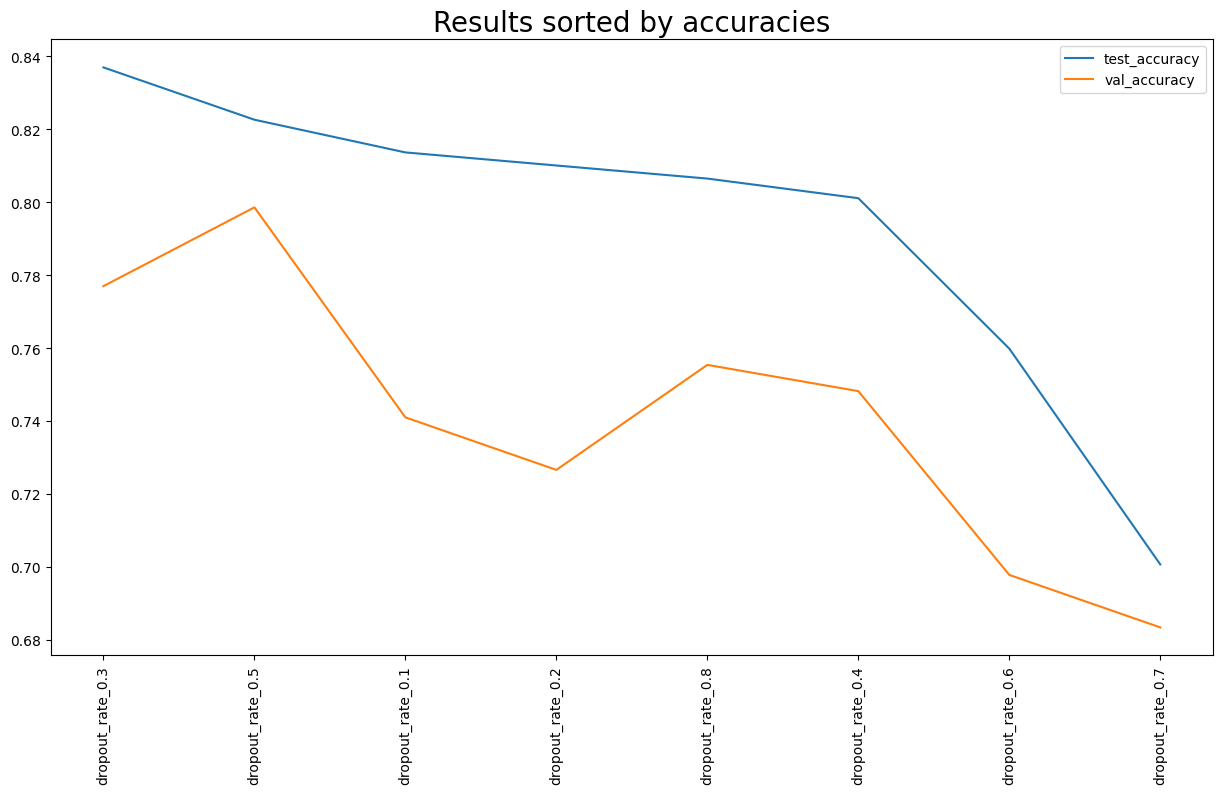

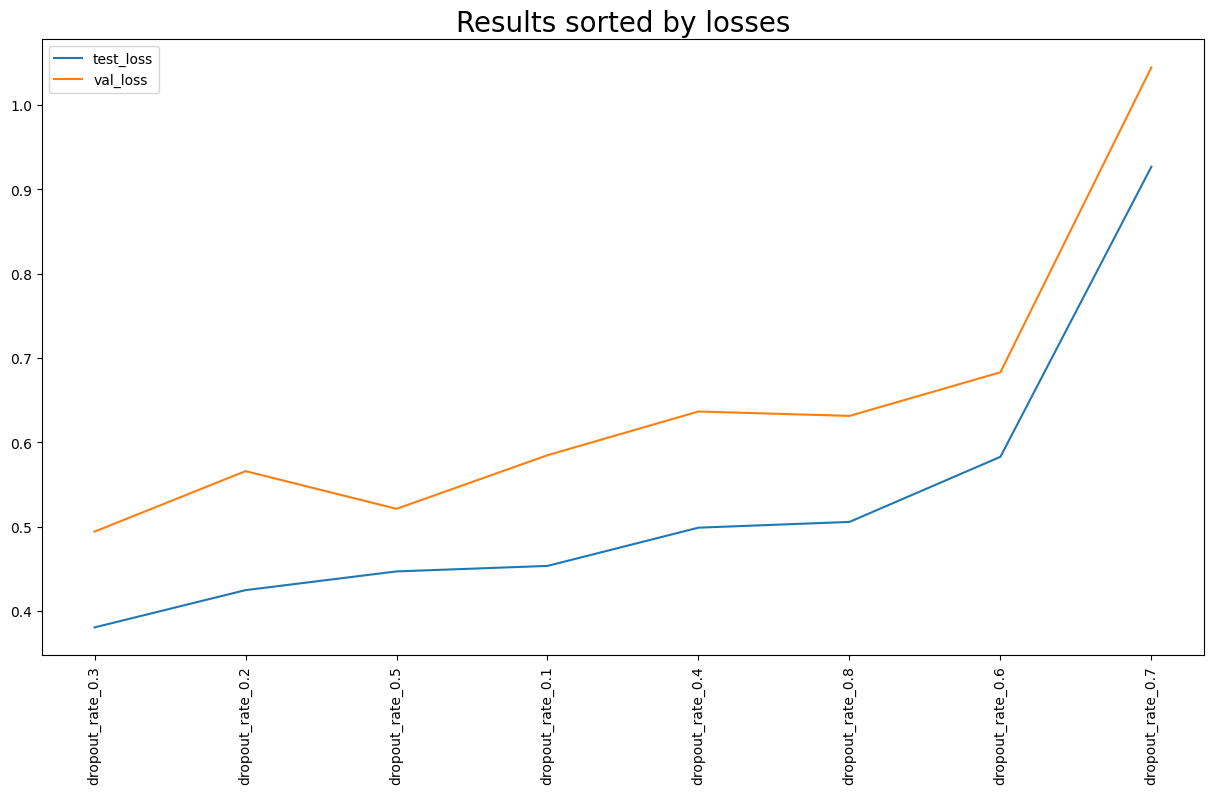

Testing now the parameters:{'optimizer': 'rmsprop'}.

Epoch 1/100
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.3650 - loss: 2.6026
Epoch 1: val_loss improved from inf to 28.07244, saving model to models/custom_model/custom_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.3694 - loss: 2.5506 - val_accuracy: 0.4820 - val_loss: 28.0724
Epoch 2/100
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.5135 - loss: 1.1431
Epoch 2: val_loss did not improve from 28.07244
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.5129 - loss: 1.1421 - val_accuracy: 0.4460 - val_loss: 54.7735
Epoch 3/100
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.5277 - loss: 1.0811
Epoch 3: val_loss did not improve from 28.07244
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.5302 - loss: 1.0766 - val_accuracy: 0.4460 - val_loss: 107.8163
Epoch 4/100
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.5741 - loss: 0.9881
Epoch 4: val_loss improved from 28.07244 to

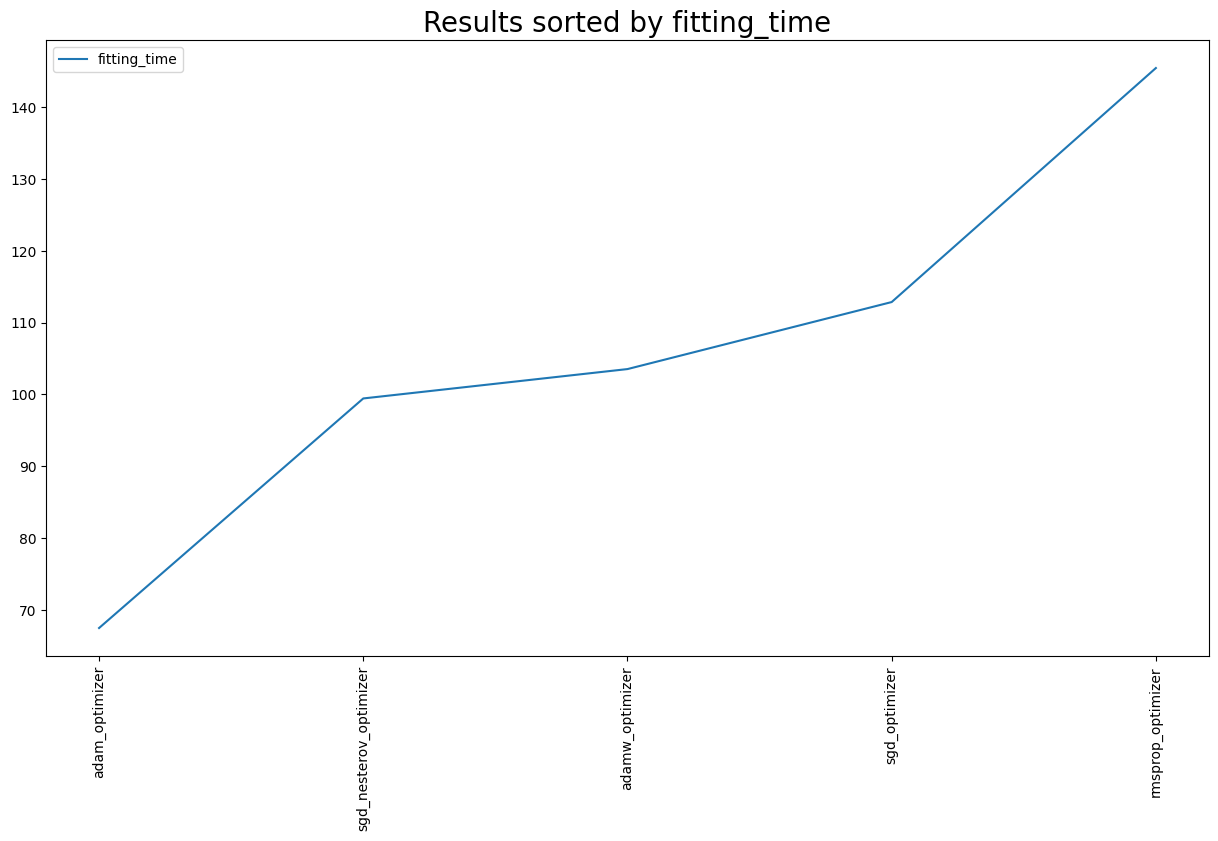

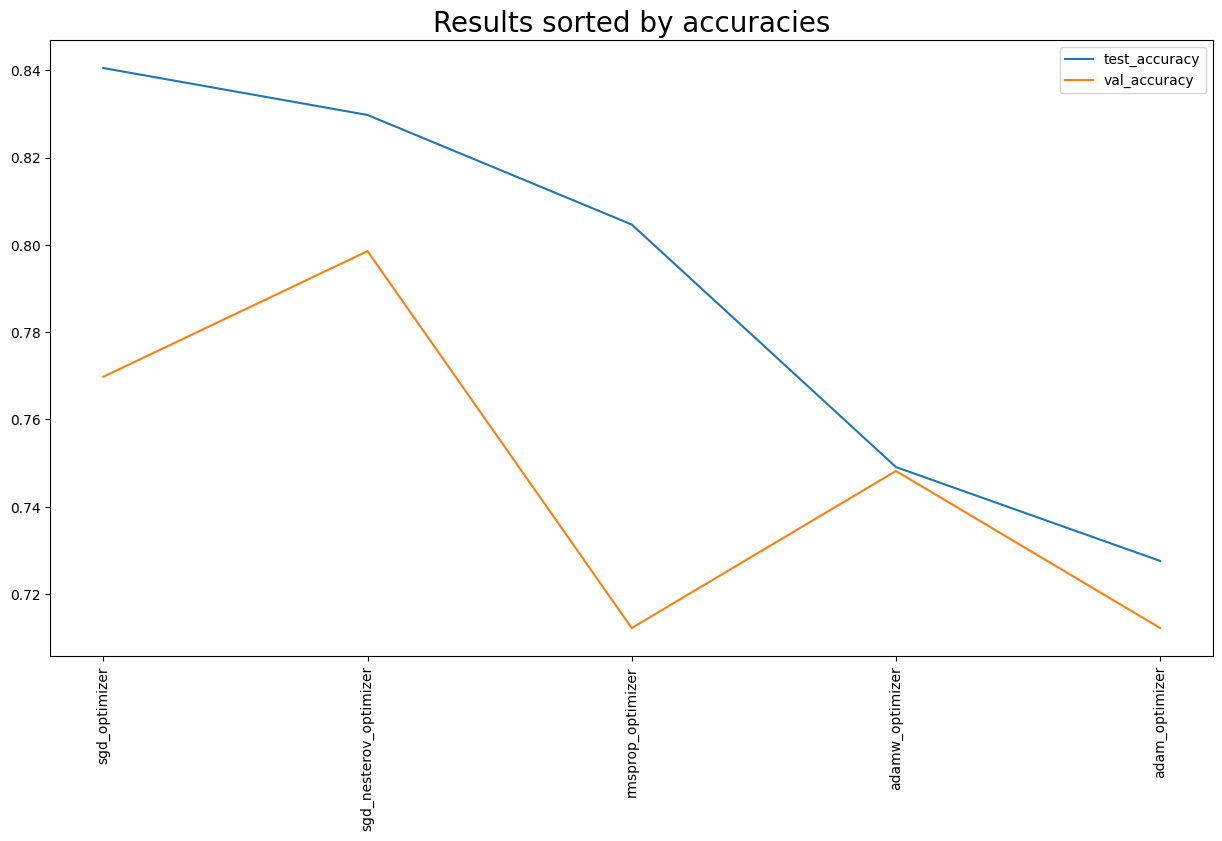

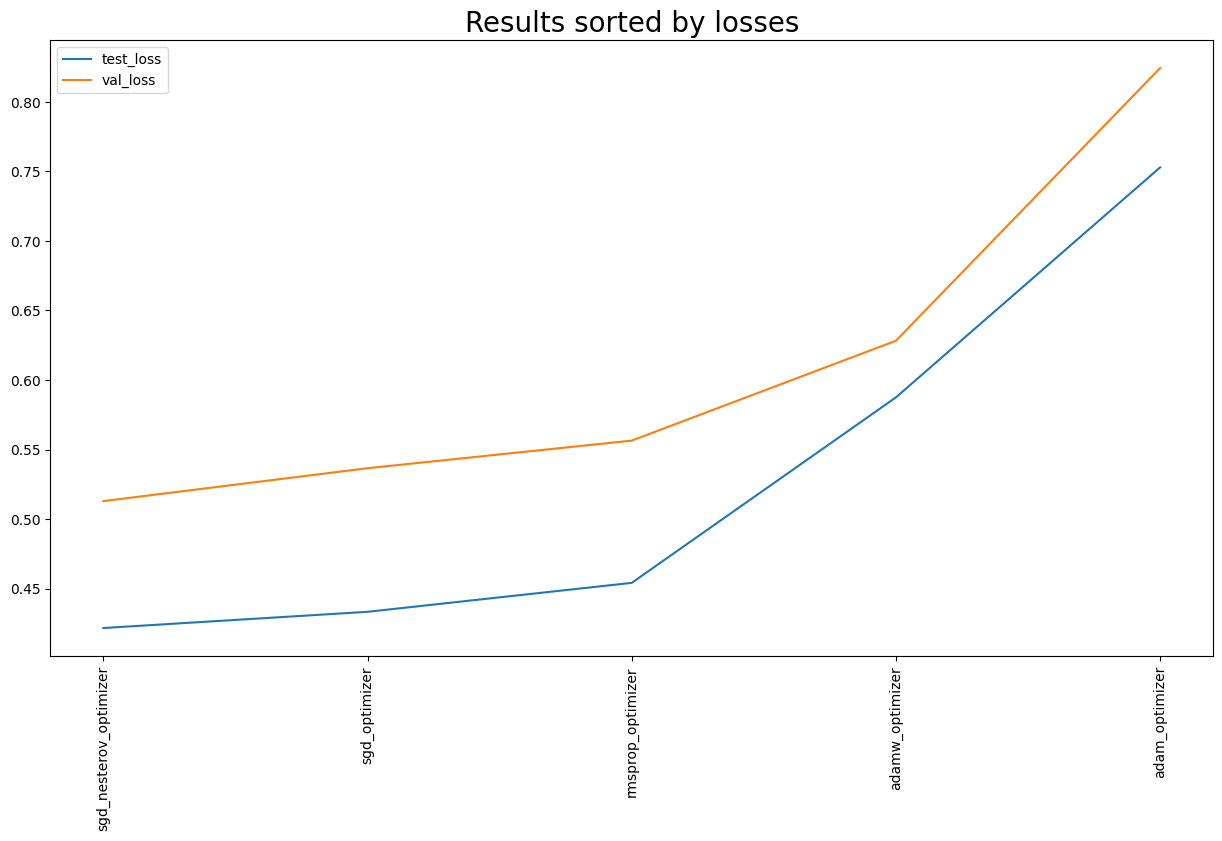

Testing now the parameters:{'learning_rate': 1e-05}.

Epoch 1/100
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.3193 - loss: 1.6954
Epoch 1: val_loss improved from inf to 1.15324, saving model to models/custom_model/custom_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 0.3193 - loss: 1.6909 - val_accuracy: 0.2518 - val_loss: 1.1532
Epoch 2/100
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.3501 - loss: 1.5617
Epoch 2: val_loss improved from 1.15324 to 1.13851, saving model to models/custom_model/custom_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.3511 - loss: 1.5607 - val_accuracy: 0.2662 - val_loss: 1.1385
Epoch 3/100
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.3727 - loss: 1.5299
Epoch 3: val_loss improved from 1.13851 to 1.13122, saving model to models/custom_model/custom_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.3712 - loss: 1.5317 - val_accuracy: 0.2734 - val_loss: 1.1312
Epoch 4/100
26/27

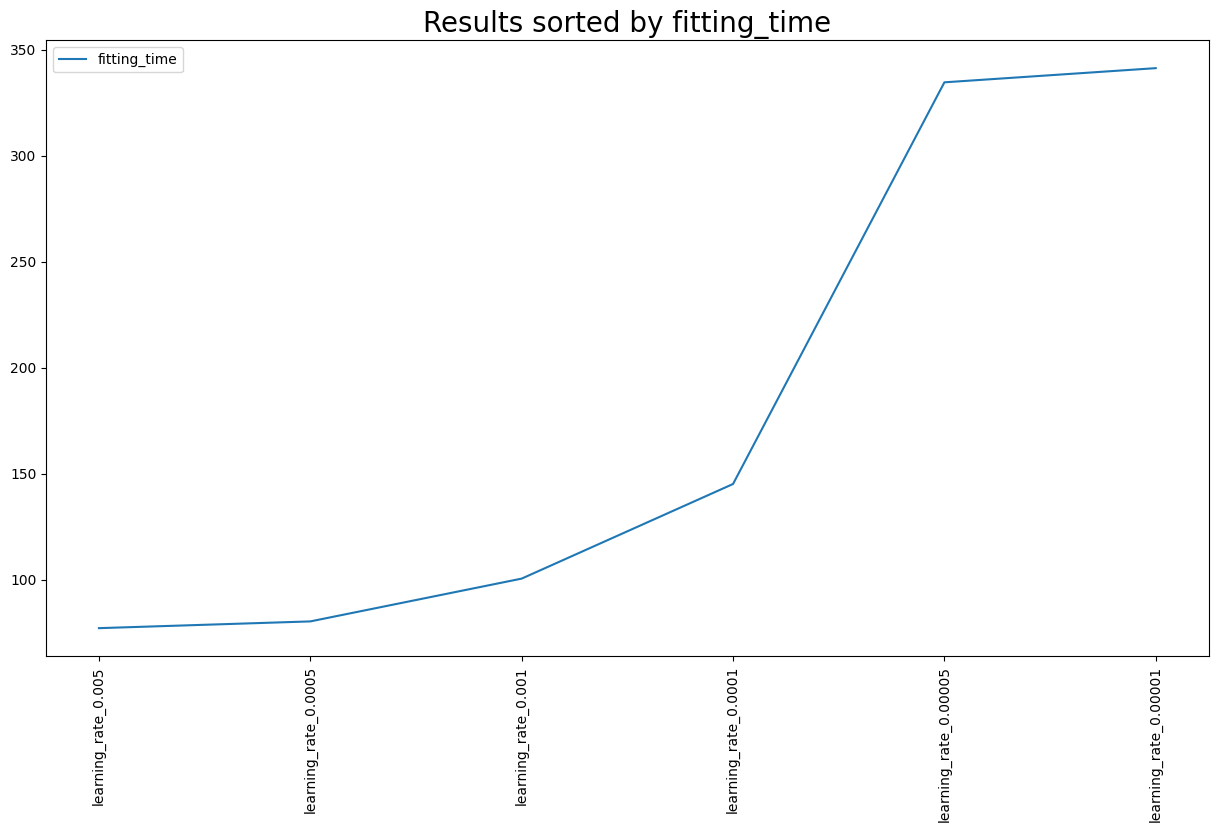

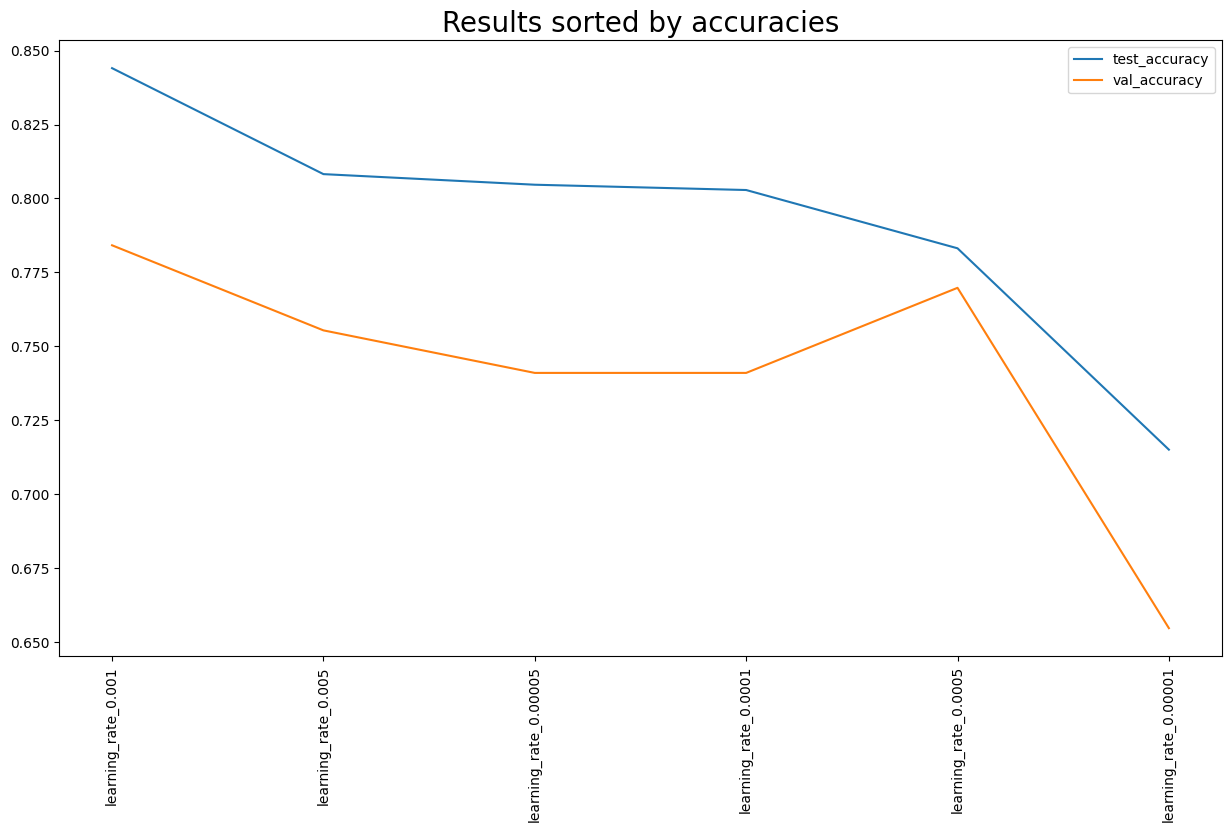

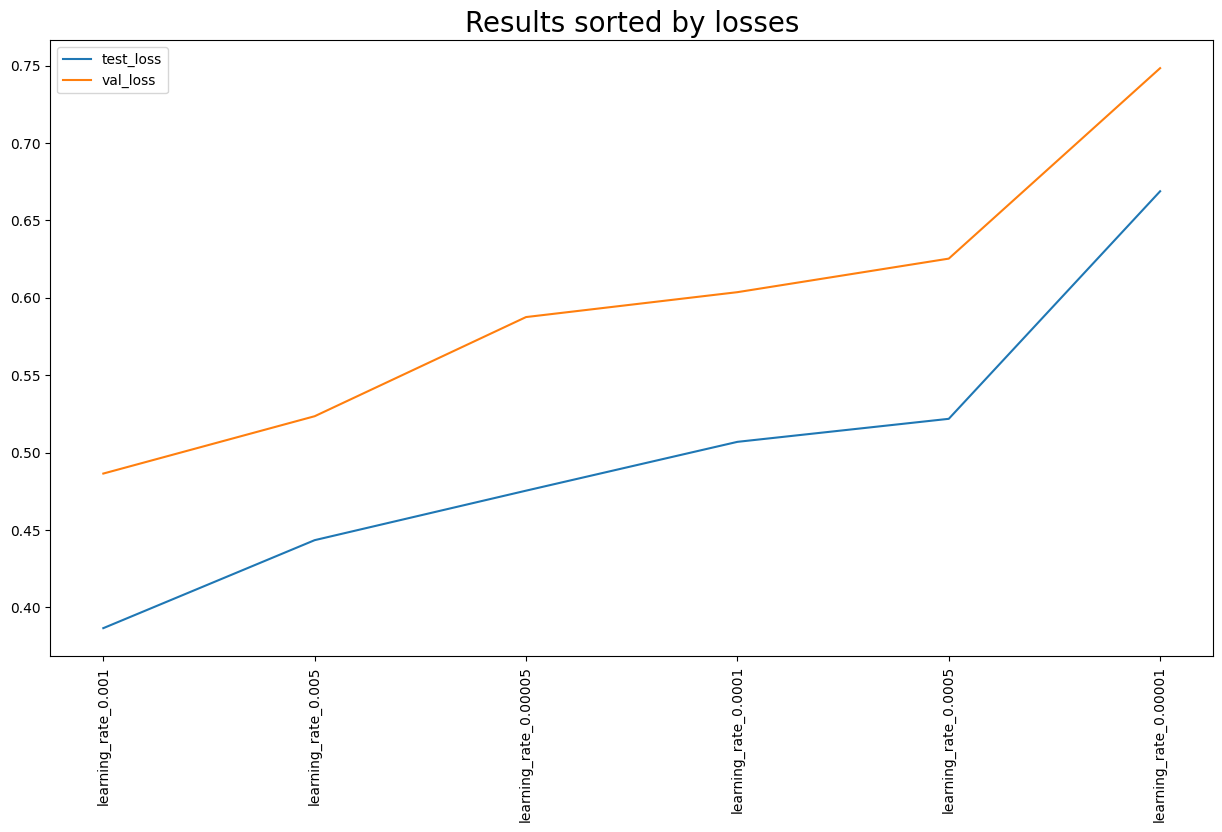

Testing now the parameters:{'epoch': 25, 'with_early_stopping': False}.

Epoch 1/25
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.4982 - loss: 1.1836
Epoch 1: val_loss improved from inf to 1.24245, saving model to models/custom_model/custom_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 0.5015 - loss: 1.1791 - val_accuracy: 0.4460 - val_loss: 1.2424
Epoch 2/25
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.5757 - loss: 0.9508
Epoch 2: val_loss improved from 1.24245 to 1.00041, saving model to models/custom_model/custom_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.5789 - loss: 0.9457 - val_accuracy: 0.5180 - val_loss: 1.0004
Epoch 3/25
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.6221 - loss: 0.8689
Epoch 3: val_loss did not improve from 1.00041
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.6220 - loss: 0.8703 - val_accuracy: 0.4676 - val_loss: 1.3550
Epoch 4/25
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accurac

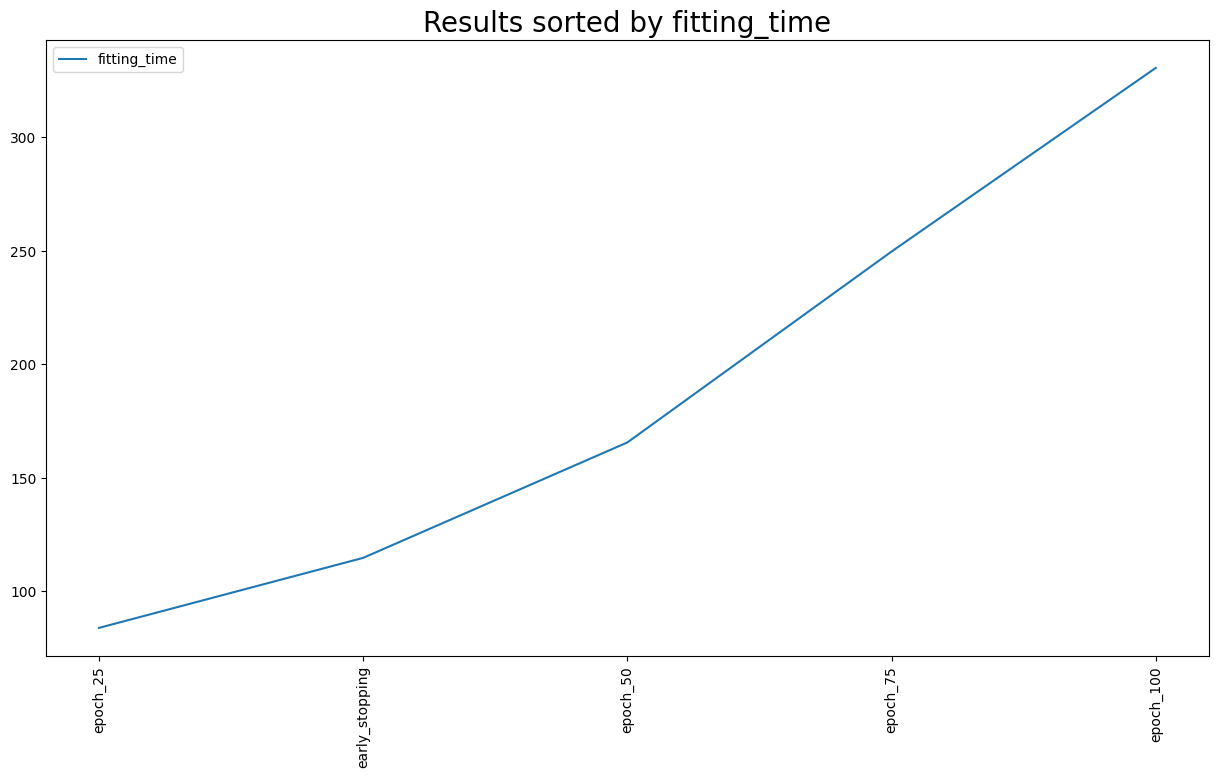

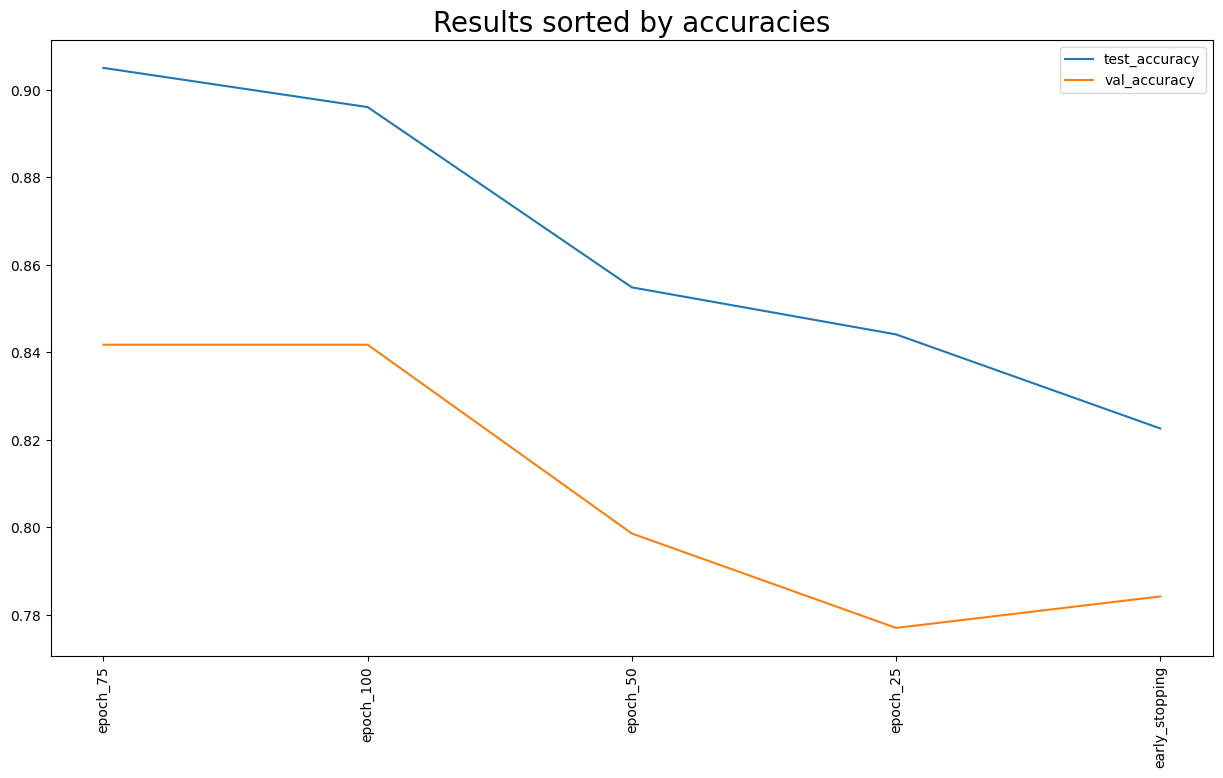

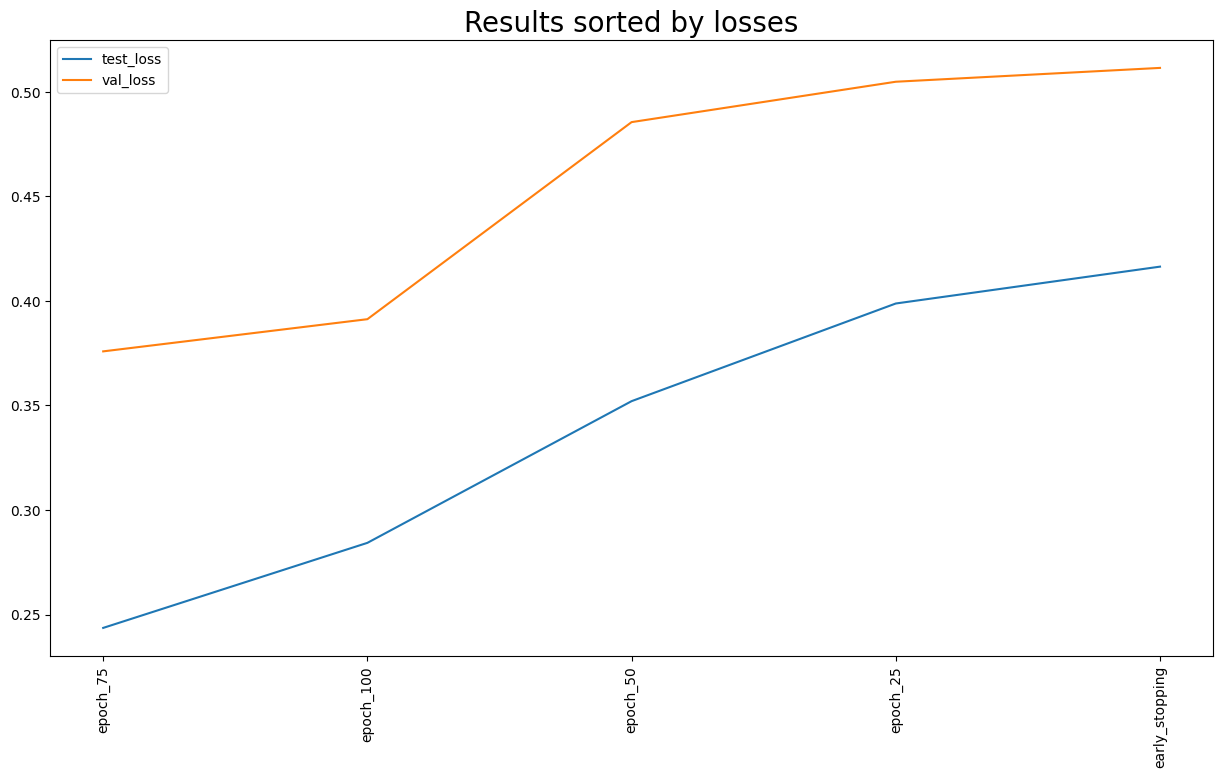

Testing now the parameters:{'batch_size': 4}.

Found 558 files belonging to 3 classes.
Using 419 files for training.
Found 558 files belonging to 3 classes.
Using 139 files for validation.
Found 558 files belonging to 3 classes.
Epoch 1/75


2024-09-26 15:12:25.679902: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4286 - loss: 1.3613
Epoch 1: val_loss improved from inf to 1.20921, saving model to models/custom_model/custom_model.keras
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.4290 - loss: 1.3602 - val_accuracy: 0.4964 - val_loss: 1.2092
Epoch 2/75
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5904 - loss: 1.0688
Epoch 2: val_loss did not improve from 1.20921
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.5903 - loss: 1.0685 - val_accuracy: 0.5108 - val_loss: 1.5799
Epoch 3/75
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.5975 - loss: 1.0066
Epoch 3: val_loss improved from 1.20921 to 0.77063, saving model to models/custom_model/custom_model.keras
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.5975 - loss: 1.0074 - val_accuracy: 0.6619 - val_loss: 0.7706
Epoch 4/75
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6094 - loss: 1.0164
Epoch 4: val_loss did not improve from 0.77063
105/1

2024-09-26 15:18:52.487696: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.4348 - loss: 1.4042

2024-09-26 15:18:58.451242: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.41GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-09-26 15:18:58.455623: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.25GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.



Epoch 1: val_loss improved from inf to 1.06669, saving model to models/custom_model/custom_model.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - accuracy: 0.4377 - loss: 1.3969 - val_accuracy: 0.3813 - val_loss: 1.0667
Epoch 2/75
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.6294 - loss: 0.9427
Epoch 2: val_loss did not improve from 1.06669
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - accuracy: 0.6285 - loss: 0.9438 - val_accuracy: 0.4892 - val_loss: 1.1882
Epoch 3/75
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.6145 - loss: 1.0230
Epoch 3: val_loss improved from 1.06669 to 0.96347, saving model to models/custom_model/custom_model.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.6156 - loss: 1.0195 - val_accuracy: 0.5324 - val_loss: 0.9635
Epoch 4/75
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.6036 - loss: 0.8958
Epoch 4: val_loss improved from 0.96347 to 0.58363, saving model to models/custom_model/custom_model.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 8

2024-09-26 15:28:36.533005: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.18GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-09-26 15:28:36.899758: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 662.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-09-26 15:28:36.899801: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.16GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-09-26 15:28:37.607714: W external/local_tsl/tsl/framework/bf

13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.3748 - loss: 1.4201
Epoch 1: val_loss improved from inf to 1.05980, saving model to models/custom_model/custom_model.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 15s 562ms/step - accuracy: 0.3850 - loss: 1.3971 - val_accuracy: 0.5396 - val_loss: 1.0598
Epoch 2/75
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.5358 - loss: 1.0868
Epoch 2: val_loss did not improve from 1.05980
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 232ms/step - accuracy: 0.5397 - loss: 1.0825 - val_accuracy: 0.3022 - val_loss: 1.2751
Epoch 3/75
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.6873 - loss: 0.8399
Epoch 3: val_loss did not improve from 1.05980
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 232ms/step - accuracy: 0.6851 - loss: 0.8425 - val_accuracy: 0.4460 - val_loss: 1.2780
Epoch 4/75
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.5925 - loss: 0.9758
Epoch 4: val_loss improved from 1.05980 to 0.99930, saving model to models/custom_model/custom_model.keras
14/14 ━━━━━

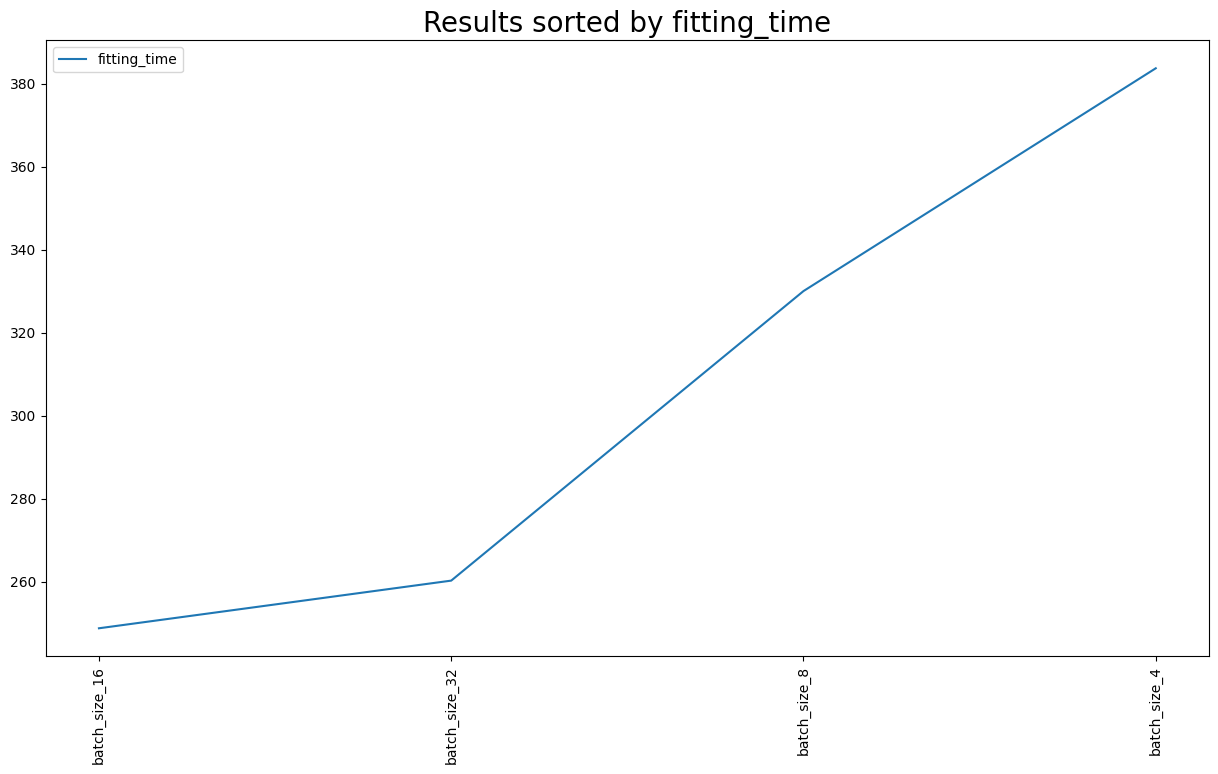

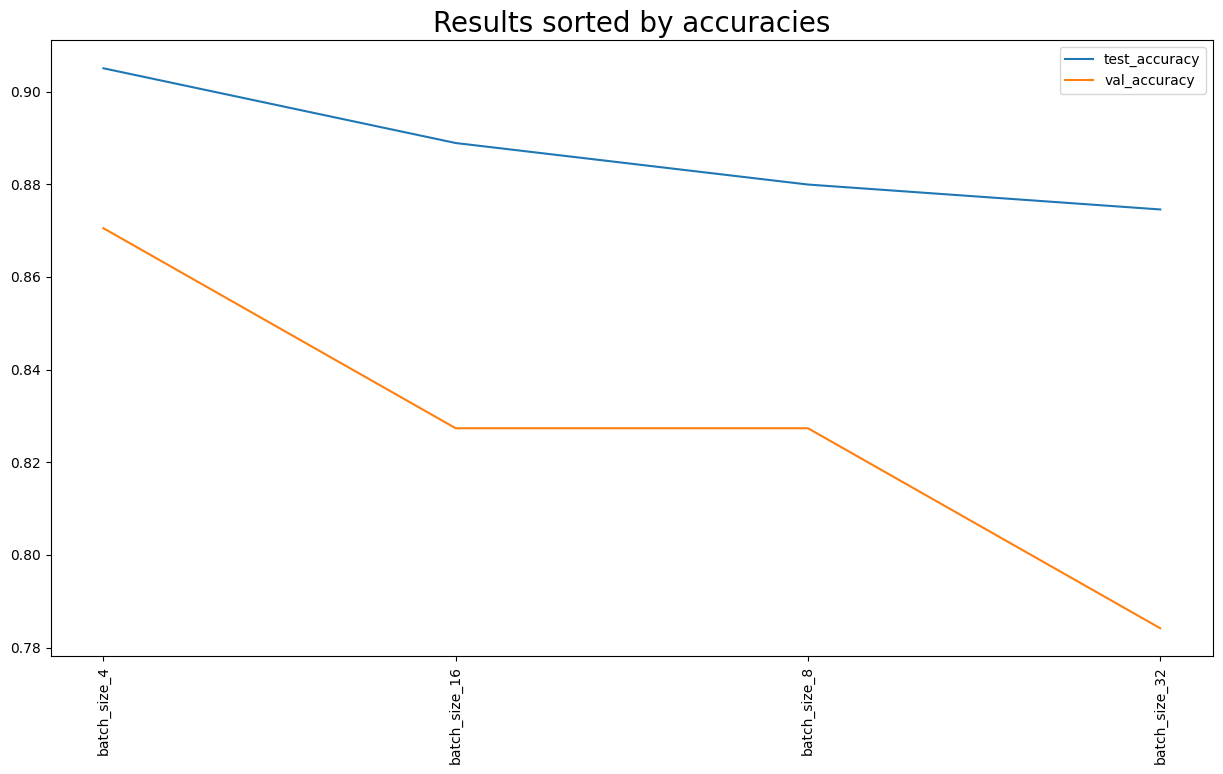

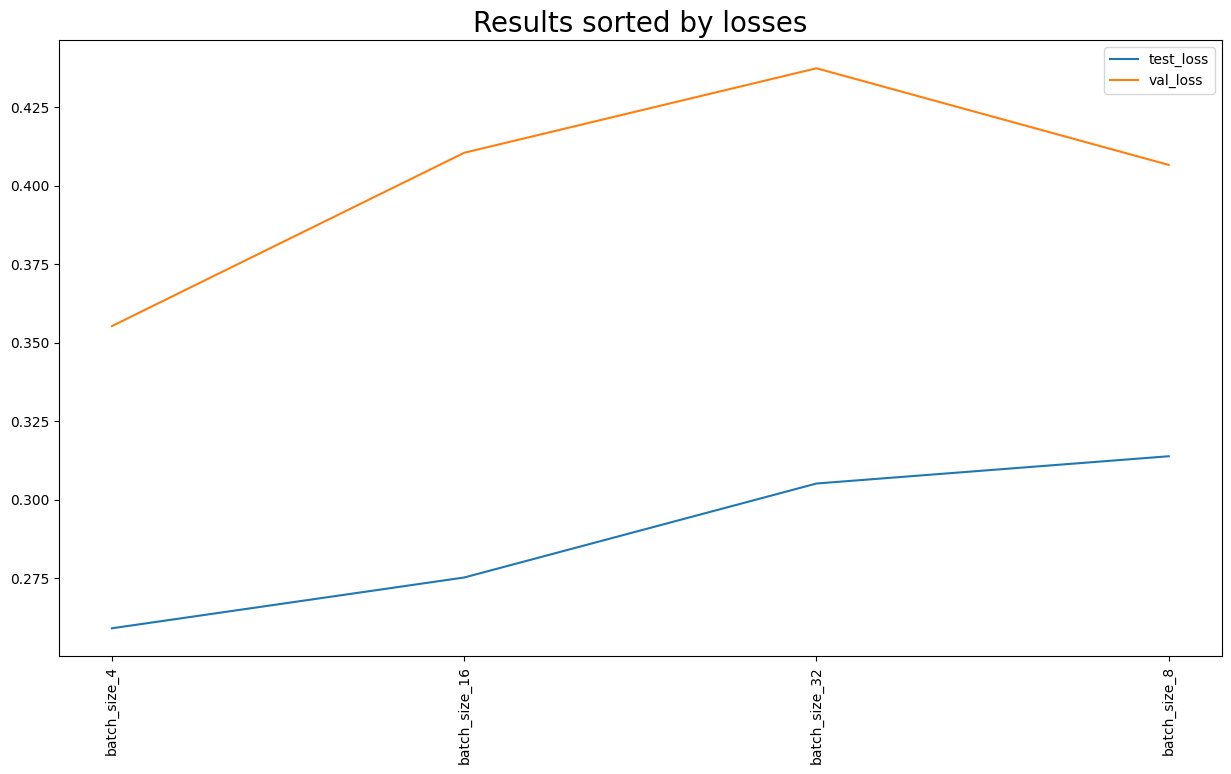

Hyperoptimization now done. Best hyperparameters found:{'number_of_intermediate_layers': 5, 'kernel_size': (5, 5), 'dropout_rate': 0.5, 'optimizer': 'sgdn', 'learning_rate': 0.001, 'epoch': 75, 'with_early_stopping': False, 'batch_size': 4}.

Custom models learning script finished.



In [14]:
if __name__ == '__main__':
    print("Starting custom models learning script.\n")
    remove_last_generated_models()
    
    image_size = (224, 224)
    batch_size = 16
    labels_number = 3
    
    dataset_train = get_dataset(CROPPED_IMAGES_PATH, image_size, batch_size, validation_split=0.25,
                                data_type='training')
    dataset_val = get_dataset(CROPPED_IMAGES_PATH, image_size, batch_size, validation_split=0.25,
                              data_type='validation')
    dataset_test = get_dataset(CROPPED_IMAGES_PATH, image_size, batch_size, data_type=None)
    
    best_layers_parameters = {}

    
    # MODEL HYPEROPTIMIZATION
    results = []
    for hyperparameters in [
        {"name": "1_intermediate_layers", "parameters": {"number_of_intermediate_layers": 1}},
        {"name": "2_intermediate_layers", "parameters": {"number_of_intermediate_layers": 2}},
        {"name": "3_intermediate_layers", "parameters": {"number_of_intermediate_layers": 3}},
        {"name": "4_intermediate_layers", "parameters": {"number_of_intermediate_layers": 4}},
        {"name": "5_intermediate_layers", "parameters": {"number_of_intermediate_layers": 5}}
    ]:
        print(f"\nTesting now the parameters:{hyperparameters["parameters"]}.\n")
        model = create_model(input_shape=image_size + (3,), labels_number=labels_number,
                             **hyperparameters["parameters"])
        results.append(get_results_of_model(model, dataset_train, dataset_val, dataset_test,
                                            hyperparameters["parameters"]))
        
    sorted_results = sorted(results, key=lambda x: x["val_accuracy"], reverse=True)
    best_layers_parameters["number_of_intermediate_layers"] = get_best_parameter(sorted_results,
                                                                                 "number_of_intermediate_layers")
    display_results(sorted_results, "number_of_intermediate_layers")
    
    results = []
    for hyperparameters in [
        {"name": "kernel_layer_size_1", "parameters": {"kernel_size": (1, 1)}},
        {"name": "kernel_layer_size_2", "parameters": {"kernel_size": (2, 2)}},
        {"name": "kernel_layer_size_3", "parameters": {"kernel_size": (3, 3)}},
        {"name": "kernel_layer_size_4", "parameters": {"kernel_size": (4, 4)}},
        {"name": "kernel_layer_size_5", "parameters": {"kernel_size": (5, 5)}}
    ]:
        print(f"Testing now the parameters:{hyperparameters["parameters"]}.\n")
        model = create_model(input_shape=image_size + (3,), labels_number=labels_number,
                             number_of_intermediate_layers=best_layers_parameters["number_of_intermediate_layers"],
                             **hyperparameters["parameters"])
        keras.backend.clear_session()
        results.append(get_results_of_model(model, dataset_train, dataset_val, dataset_test,
                                            hyperparameters["parameters"]))
        
    sorted_results = sorted(results, key=lambda x: x["val_accuracy"], reverse=True)
    best_layers_parameters["kernel_size"] = get_best_parameter(sorted_results, "kernel_size")
    display_results(sorted_results, "kernel_size")
    
    results = []
    for hyperparameters in [
        {"name": "dropout_rate_0.1", "parameters": {"dropout_rate": 0.1}},
        {"name": "dropout_rate_0.2", "parameters": {"dropout_rate": 0.2}},
        {"name": "dropout_rate_0.3", "parameters": {"dropout_rate": 0.3}},
        {"name": "dropout_rate_0.4", "parameters": {"dropout_rate": 0.4}},
        {"name": "dropout_rate_0.5", "parameters": {"dropout_rate": 0.5}},
        {"name": "dropout_rate_0.6", "parameters": {"dropout_rate": 0.6}},
        {"name": "dropout_rate_0.7", "parameters": {"dropout_rate": 0.7}},
        {"name": "dropout_rate_0.8", "parameters": {"dropout_rate": 0.8}},
    ]:
        print(f"Testing now the parameters:{hyperparameters["parameters"]}.\n")
        model = create_model(input_shape=image_size + (3,), labels_number=labels_number,
                             number_of_intermediate_layers=best_layers_parameters["number_of_intermediate_layers"],
                             kernel_size=best_layers_parameters["kernel_size"], **hyperparameters["parameters"])
        results.append(get_results_of_model(model, dataset_train, dataset_val, dataset_test,
                                            hyperparameters["parameters"]))
        
    sorted_results = sorted(results, key=lambda x: x["val_accuracy"], reverse=True)
    best_layers_parameters["dropout_rate"] = get_best_parameter(sorted_results, "dropout_rate")
    display_results(sorted_results, "dropout_rate")

    
    # COMPILATION HYPEROPTIMIZATION
    results = []
    for hyperparameters in [
        {"name": "rmsprop_optimizer", "parameters": {"optimizer": "rmsprop"}},
        {"name": "adam_optimizer", "parameters": {"optimizer": "adam"}},
        {"name": "adamw_optimizer", "parameters": {"optimizer": "adamw"}},
        {"name": "sgd_optimizer", "parameters": {"optimizer": "sgd"}},
        {"name": "sgd_nesterov_optimizer", "parameters": {"optimizer": "sgdn"}},
    ]:
        print(f"Testing now the parameters:{hyperparameters["parameters"]}.\n")
        model = create_model(input_shape=image_size + (3,), labels_number=labels_number,
                             number_of_intermediate_layers=best_layers_parameters["number_of_intermediate_layers"],
                             kernel_size=best_layers_parameters["kernel_size"],
                             dropout_rate=best_layers_parameters["dropout_rate"],
                             **hyperparameters["parameters"])
        results.append(get_results_of_model(model, dataset_train, dataset_val, dataset_test,
                                            hyperparameters["parameters"]))
        
    sorted_results = sorted(results, key=lambda x: x["val_accuracy"], reverse=True)
    best_layers_parameters["optimizer"] = get_best_parameter(sorted_results, "optimizer")
    display_results(sorted_results, "optimizer")
    
    results = []
    for hyperparameters in [
        {"name": "learning_rate_0.00001", "parameters": {"learning_rate": 0.00001}},
        {"name": "learning_rate_0.00005", "parameters": {"learning_rate": 0.00005}},
        {"name": "learning_rate_0.0001", "parameters": {"learning_rate": 0.0001}},
        {"name": "learning_rate_0.0005", "parameters": {"learning_rate": 0.0005}},
        {"name": "learning_rate_0.001", "parameters": {"learning_rate": 0.001}},
        {"name": "learning_rate_0.005", "parameters": {"learning_rate": 0.005}}
    ]:
        print(f"Testing now the parameters:{hyperparameters["parameters"]}.\n")
        model = create_model(input_shape=image_size + (3,), labels_number=labels_number,
                             number_of_intermediate_layers=best_layers_parameters["number_of_intermediate_layers"],
                             kernel_size=best_layers_parameters["kernel_size"],
                             dropout_rate=best_layers_parameters["dropout_rate"],
                             optimizer=best_layers_parameters["optimizer"],
                             **hyperparameters["parameters"])
        results.append(get_results_of_model(model, dataset_train, dataset_val, dataset_test,
                                            hyperparameters["parameters"]))
        
    sorted_results = sorted(results, key=lambda x: x["val_accuracy"], reverse=True)
    best_layers_parameters["learning_rate"] = get_best_parameter(sorted_results, "learning_rate")
    display_results(sorted_results, "learning_rate")

    # EXECUTION HYPEROPTIMIZATION
    results = []
    for hyperparameters in [
        {"name": "epoch_25", "parameters": {"epoch": 25, "with_early_stopping": False}},
        {"name": "epoch_50", "parameters": {"epoch": 50, "with_early_stopping": False}},
        {"name": "epoch_75", "parameters": {"epoch": 75, "with_early_stopping": False}},
        {"name": "epoch_100", "parameters": {"epoch": 100, "with_early_stopping": False}},
        {"name": "early_stopping", "parameters": {"epoch": 100, "with_early_stopping": True}},
    ]:
        print(f"Testing now the parameters:{hyperparameters["parameters"]}.\n")
        model = create_model(input_shape=image_size + (3,), labels_number=labels_number,
                             number_of_intermediate_layers=best_layers_parameters["number_of_intermediate_layers"],
                             kernel_size=best_layers_parameters["kernel_size"],
                             dropout_rate=best_layers_parameters["dropout_rate"],
                             optimizer=best_layers_parameters["optimizer"],
                             learning_rate=best_layers_parameters["learning_rate"])
        results.append(get_results_of_model(model, dataset_train, dataset_val, dataset_test,
                                            hyperparameters["parameters"], **hyperparameters["parameters"]))
        
    sorted_results = sorted(results, key=lambda x: x["val_accuracy"], reverse=True)
    best_layers_parameters["epoch"] = get_best_parameter(sorted_results, "epoch")
    best_layers_parameters["with_early_stopping"] = get_best_parameter(sorted_results, "with_early_stopping")
    display_results(sorted_results, "epoch")
    
    results = []
    for hyperparameters in [
        {"name": "batch_size_4", "parameters": {"batch_size": 4}},
        {"name": "batch_size_8", "parameters": {"batch_size": 8}},
        {"name": "batch_size_16", "parameters": {"batch_size": 16}},
        {"name": "batch_size_32", "parameters": {"batch_size": 32}},
    ]:
        print(f"Testing now the parameters:{hyperparameters["parameters"]}.\n")
        model = create_model(input_shape=image_size + (3,), labels_number=labels_number,
                             number_of_intermediate_layers=best_layers_parameters["number_of_intermediate_layers"],
                             kernel_size=best_layers_parameters["kernel_size"],
                             dropout_rate=best_layers_parameters["dropout_rate"],
                             optimizer=best_layers_parameters["optimizer"],
                             learning_rate=best_layers_parameters["learning_rate"])
        
        new_batch_size = hyperparameters["parameters"]["batch_size"]
        dataset_train = get_dataset(CROPPED_IMAGES_PATH, image_size, new_batch_size, validation_split=0.25,
                                    data_type='training')
        dataset_val = get_dataset(CROPPED_IMAGES_PATH, image_size, new_batch_size, validation_split=0.25,
                                  data_type='validation')
        dataset_test = get_dataset(CROPPED_IMAGES_PATH, image_size, new_batch_size, data_type=None)
        
        results.append(get_results_of_model(model, dataset_train, dataset_val, dataset_test, 
                                            hyperparameters["parameters"], epoch=best_layers_parameters["epoch"],
                                            with_early_stopping=best_layers_parameters["with_early_stopping"],
                                            batch_size=new_batch_size))
        
    sorted_results = sorted(results, key=lambda x: x["val_accuracy"], reverse=True)
    best_layers_parameters["batch_size"] = get_best_parameter(sorted_results, "batch_size")
    display_results(sorted_results, "batch_size")
    
    print(f"Hyperoptimization now done. Best hyperparameters found:{best_layers_parameters}.\n")
    
    print("Custom models learning script finished.\n")